<a href="https://www.kaggle.com/code/hattoriyoung/random-forest-from-scratch?scriptVersionId=221563951" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#### **Random Forest From Scratch**

**Introduction**

Random Forest is an ensemble learning method for classification and regression. An ***ensemble learning*** method is it combines the predictions of multiple weak models to make a stronger, more reliable prediction. That way it is able to reduce errors and improve performance. Esemble Learning are also cateogirsed as 
* *Bagging*
* *Boosting*

Random Forest uses the former.

What is Random Forest? It essentially takes a collection of weaker decision trees that is trained by ***bootstraping*** (*sampling with replacement*) your data. This bootstrapping method is applied to both features and data, meaning your data can have repeats and your features will also have repeats. Afterwards, after training each of your individual decision trees, the trees will make the predictions individually and for classification, majority voting is implemented while regression, we take the average of all the results of the trees; This entire process is called ***Bagging***. 

This algorithim is also non-parametric like the decision trees, however, different from the decision tree, the random forest algorithim are uncorrelated and solves the overfitting issue. 

The algorithim has alot of relevance to the decision tree alogirthim, therefore, if you have any questions or unfamiliar with the decision trees, you can check out on my profile which I also implemented from scratch: [Decision Trees From Scratch](https://www.kaggle.com/code/hattoriyoung/dt-from-scratch)

P.S Cool thing about random forest is that is able to find features that contribute to the reduction in impurity, which evaluates feature importantance. 

**Assumptions**

* Each tree makes its own decisions: Every tree in the forest makes its own predictions without relying on others.
* Random parts of the data are used: Each tree is built using random samples and features to reduce mistakes.
* Enough data is needed: Sufficient data ensures the trees are different and learn unique patterns and variety.
* Different predictions improve accuracy: Combining the predictions from different trees leads to a more accurate final results.

**Goal**

The Goal of this excerise is to implement the alogrithim from scratch without using any frameworks.

**Motivation**

As for the motivation, these kind of excerises are good for any data science interview preperation as you are able to get the fundementals down. Understand how the algorithim works and not treating it like a black box function will help you become a better data scientist.

-----

### **Python Implementation From Scratch**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt # plot

from collections import Counter

In [2]:
mydf = pd.read_csv("/kaggle/input/mountains-vs-beaches-preference/mountains_vs_beaches_preferences.csv")

For simplicity, we will be choosing these following variables for our model creation. 
- `Age`: Age of the individual (numerical).
- `Travel_Frequency`: Number of vacations taken per year 
- `Vacation_Budget`: The individual's budget when going on vacation.
- `Pets`: Indicates whether the individual owns pets (binary: 0 = No, 1 = Yes).

Given the fact that decision trees are prone to overfitting, let's just keep our features to the minimum and simple. Random forest can be a good alternative in most cases when your data is more complex. 

*NOTE: Generally, having domain knowledge about your data is important to choose the right features if you have loads to feature to choose from. That being said, there are many use cases in using feature selection techniques to accomplish this.*

In [3]:
mydf = mydf[["Age","Travel_Frequency","Vacation_Budget","Pets","Preference"]]
mydf.head(n = 10)

,Age,Travel_Frequency,Vacation_Budget,Pets,Preference
0,56,9,2477,0,1
1,69,1,4777,0,0
2,46,0,1469,0,1
3,32,6,1482,1,1
4,60,5,516,1,0
5,25,3,2895,0,0
6,38,1,4994,0,0
7,56,8,3656,1,0
8,36,6,2408,1,0
9,40,1,4044,1,0


------------

### 1. **Random Forest Using Sklearn**

Split features and outcome variables as well as create 80/20 Train & Test set.

Important Hyperparameters to understand if you are using Random Forest alogirithim to solve your problem.

- **n_estimators**: # of trees in your random forest. More trees mean better model performance.
- **max_features**: # of features when splitting a node. This makes sure that the tree will not overfit as it controls how many features in a tree.
- **max_depth**: This controls the depth of the tree, the deeper the tree is, the more it is prone to overfitting
- **min_sample_split**: This controls the minimum # of samples to split per node.
- **max_leaf_nodes**: Controls the # of leaf nodes in a tree, hence, controlling the model size & complexity.
- **max_sample**: Controls how much data are given per tree based on our training set.



In [4]:
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import tree

from collections import Counter
from scipy.stats import mode

In [5]:
X_data = mydf[["Age","Travel_Frequency","Vacation_Budget","Pets"]].values
Y_target = mydf["Preference"].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_data,Y_target, random_state=42, test_size=0.2)

In [7]:
def random_forest(estimator,depth,min_split):
    model = RandomForestClassifier(n_estimators = estimator, max_depth = depth, min_samples_split = min_split,random_state = 42)
    return model.fit(X_train,y_train)

In [8]:
def prediction(X_test,clf):
    y_pred = clf.predict(X_test)
    return y_pred

In [9]:
def accuracy(y_test, pred):
    return accuracy_score(y_test,pred)

In [10]:
# train
rf_model = random_forest(estimator = 200, depth = 15, min_split = 30)

In [11]:
# Predict
pred_rf = prediction(X_test,rf_model)

In [12]:
result = accuracy(y_test, pred_rf)
classification_rep = classification_report(y_test, pred_rf)

In [13]:
print(f"Accuracy: {round(result,4) * 100}%")
print("\nClassification Report:\n", classification_rep)

Accuracy: 74.83999999999999%

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86      7851
           1       0.00      0.00      0.00      2638

    accuracy                           0.75     10489
   macro avg       0.37      0.50      0.43     10489
weighted avg       0.56      0.75      0.64     10489



----------------

### 2. Random Forest From Scratch

#### **Gini vs Entropy AND Information Gain**

* **Gini**: Measures the likelihood of an incorrect classification of a new instance if it was randomly classified according to the distribution of classes in the dataset.
    * Defined as $G = 1 - \Sigma p^2_j$, where $p_j$ is the probability of class j.

<br>

* **Entropy**: Measures the amount of uncertainty or impurity in the dataset.
    * Defined as $H(X) = -\Sigma p_j*log(p_j)$, where $p_j$ is the probability of class j.

<br>

* **Information Gain (IG)**: Measures the reduction in entropy or Gini impurity after a dataset is split on an attribute.
    * Defined as $IG(D) = I(D_p) - (\frac{N_{left}}{N_p} * I(D_{left}) - \frac{N_{right}}{N_p} * I(D_{right}))$, where $D_p,D_{left},D_{right}$ represent the datasets from the parent, left, and right children nodes, $N_p, N_{left}, N_{right}$ represent the number of observations in the parent, left and right children nodes and $I(D)$ denotes the entropy for that particular node.
    * Essentially, taking the difference between before the split vs after the split and determine if there is any information gain, and repeat this for each split of the feature/node.

In [14]:
class DecisionTreeFromScratch:
    def __init__(self,min_sample,max_depth,max_splits):
        self.tree = None # store tree
        self.min_sample = min_sample # min # to split node
        self.max_depth = max_depth # max depth of tree
        self.max_splits = max_splits # control complexity of tree

    def _entropy(self,y):
        label_counts = Counter(y) # count # of labels per outcome
        entropy = 0.0

        for counts in label_counts.values():
            prob = counts / len(y)
            entropy -= prob * np.log2(prob)

        return entropy # return scalar

    def _info_gain(self,parent,left_child,right_child): # calc info gain after split
        weight_l = len(left_child) / len(parent) 
        weight_r = len(right_child) / len(parent)
        gain = self._entropy(parent) - (weight_l * self._entropy(left_child) + weight_r * self._entropy(right_child))

        return gain # was the info gained from reduc entropy worth the split 

    def _best_split(self,X,y,n_features):
        best_split = {"info_gain": 0}

        for feature in range(n_features):
            feature_values = X[:,feature]
            unique_feature_values = np.unique(feature_values)

            if len(unique_feature_values) > self.max_splits: # control # of splits per feature
                unique_feature_values = np.linspace(min(feature_values),max(feature_values),self.max_splits) 

            for threshold in unique_feature_values: # for each feature, split left & right and iterate each threshold and calculate/compare info_gain
                left_index = np.where(feature_values <= threshold)
                right_index = np.where(feature_values > threshold)

                if len(left_index) == 0 or len(right_index) == 0:
                    continue

                y_left,y_right = y[left_index], y[right_index]
                gain = self._info_gain(y,y_left,y_right)

                if gain > best_split["info_gain"]: # only save the best split per feature that maximizes info_gain
                    best_split = {
                        "feature_index": feature_index,
                        "threshold": threshold,
                        "left_index": left_index,
                        "right_index": right_index,
                        "information_gain": gain
                    }

        return best_split

    def common_label(self,y):
        return Counter(y).most_common(1)[0][0]

    def _build_tree(self,X,y, depth = 0):
        n,n_features = X.shape
        n_labels = len(np.unique(y))

        if n_labels == 1 or n < self.min_sample or depth < self.max_depth: # base case
            return self.common_label(y) # return most common label

        best_split = self._best_split(X,y,n_features) # calc best split
        
        if best_split["info_gain"] == 0:
            return self.common_label(y)
        # recursively build left & right subtrees finding best_split until base case is met
        left_subtree = self._build_tree(X[best_split["left_index"]], y[best_split["left_index"]], depth + 1)
        right_subtree = self._build_tree(X[best_split["right_index"]], y[best_split["right_index"]], depth + 1)

        return {
            "feature_index": best_split["feature_index"],
            "threshold": best_split["threshold"],
            "left_tree": left_subtree,
            "right_tree": right_subtree
        }

    def fit(self,X,y):
        self.tree = self._build_tree(X,y) 
    
    def _predict_single(self,x,tree):
        if not isinstance(tree,dict): # base case: is it a leaf node?
            return tree
        
        feature_index = tree["feature_index"]
        threshold = tree["threshold"]
        
        if x[feature_index] <= threshold: # the vals for that data, do we traverse left or right?
            return self._predict_single(x, tree["left_tree"]) # traverse left, if <= threshold until base case
        else:
            return self._predict_single(x, tree["right_tree"]) # traverse right, if > threshold until base case
        
    def predict(self,X):
        return np.array([self._predict_single(x,self.tree) for x in X]) # wrapper for _predict_single, repeat x times

In [15]:
class RandomForestFromScratch:
    def __init__(self, n_estimators=10, min_sample=1, max_depth=10, max_splits=20):
        self.n_estimators = n_estimators
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.max_splits = max_splits
        self.trees = []

    def bootstrap(self, X, y):
        # Bootstrap sample with replacement
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators): 
            X_sample, y_sample = self.bootstrap(X, y)
            tree = DecisionTreeFromScratch(min_sample=self.min_sample, 
                                           max_depth=self.max_depth, 
                                           max_splits=self.max_splits)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        preds = [tree.predict(X) for tree in self.trees]
        preds = np.array(preds)
        if preds.ndim == 2 and preds.shape[0] > 1: # make sure there are more > 1 tree within rf.
            preds = mode(preds, axis=0).mode[0] # ensemble voting
        return preds

    def score(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)

In [16]:
rf_model_scratch = RandomForestFromScratch(n_estimators=200, min_sample=2, max_depth=10, max_splits=15)

In [17]:
rf_model_scratch.fit(X_train, y_train)

In [18]:
y_pred = rf_model_scratch.predict(X_test)

In [19]:
accuracy = rf_model_scratch.score(X_test, y_test)

In [20]:
print(f"Accuracy: {round(accuracy * 100,1)}%")

Accuracy: 74.8%


---------

### **Feature Importance**

Taking a look at Feature Importance on a high level

In [21]:
feature_importance = rf_model.feature_importances_

In [22]:
feature_names = mydf.columns[0:4]
feature_importance_df = pd.DataFrame({"Feature": feature_names,"Gini Importance":feature_importance}).sort_values("Gini Importance",ascending = False)

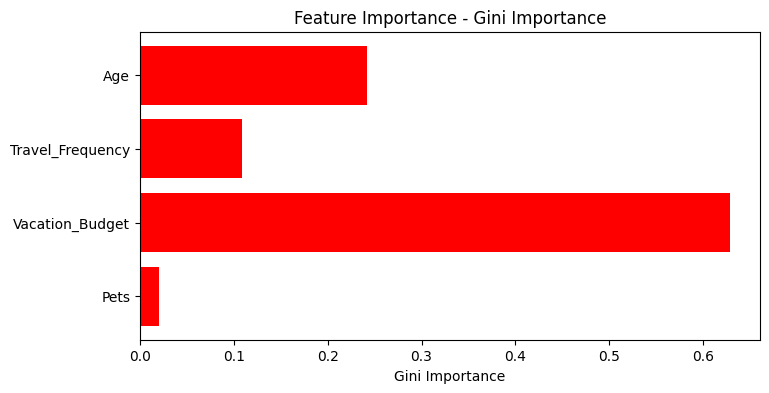

In [23]:
plt.figure(figsize=(8, 4))
plt.barh(feature_names, feature_importance, color='red')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

Gini importance utulization during feature importance is calculated by the total reduction in impurity for that feature, therefore, we can observe that `vacation_Budget` contributed the most in decreasing the impurity, as a result, given the most weight in Gini importance among multiple trees. 

-------

### **Results**

Both results are adequate resulting a ~ 75% accuracy. 

The most important thing about random forest is to be able tune the hyperparameters of the random forest. Throughout this excerise, there was alot of trial & errors in trying to make sure the Random Forest will output the most optimized results. Ofcourse, both GridSearchCV and RandomizedSearchCV can be called as part of sklearn.model_selection, however, I decided to brute force it.

The model building from scratch was not a diffcult task, as it was eseentially calling n_estimators of decision tree and having features and observations being bootstrapped. 